# Neural Text Generation

In [1]:
from seq2seq import *
from fastai.text.all import *
from utils import *

path = Config.config_path/"giga-fren"
model_path = Config.config_path/"models"
emb_enc = torch.load(model_path/"fr_emb.pth")
emb_dec = torch.load(model_path/"en_emb.pth")

In [2]:
class Seq2SeqRNN_attn(Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        self.nl, self.nh, self.out_sl, self.pr_force = nl, nh, out_sl, 1
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.emb_enc, self.emb_dec = emb_enc, emb_dec
        self.emb_sz_enc, self.emb_sz_dec = emb_enc.embedding_dim, emb_enc.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25,
                        batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2 * nh, self.emb_sz_dec, bias=False)

        self.gru_dec = nn.GRU(self.emb_sz_dec + 2 * nh, self.emb_sz_dec, num_layers=nl,
                        dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

        self.enc_att = nn.Linear(2 * nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V = self.init_param(self.emb_sz_dec)

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2 * h)

        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1, 2, 0, 3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2 * self.nh)
        hid = self.out_enc(pre_hid)

        return hid, enc_out

    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])

        # enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:, None])

        # Learn importance each time step
        attn_wgts = F.softmax(u @ self.V, 1)

        # weighted average of enc_out (output at every time step)
        ctx = (attn_wgts[..., None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)

        # Concat decoder embed with context
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:, None], hid)
        outp = self.out(self.out_drop(outp[:, 0]))
        return hid, outp

    def show(self, nm, v): 
        if False: print(f"{nm}={v[nm].shape}")

    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid, enc_out = self.encoder(bs, inp)
        # self.show("hid", vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)

        res = []

        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break

            if (targ is not None) and (random.random() < self.pr_force):
                if i >= targ.shape[1]: continue
                assert dec_inp.shape == targ[:, i].shape
                dec_inp = targ[:, i]
        
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2 * self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz) / math.sqrt(sz[0]))

In [3]:
df = pd.read_csv(path/"questions_easy.csv")
df["en"] = df["en"].apply(lambda x: x.lower())
df["fr"] = df["fr"].apply(lambda x: x.lower())
df.tail()

sl = 30  # try longer or shorter? 

dls = DataBlock(
    blocks=(TextBlock.from_df("fr", tok=SpacyTokenizer("fr"), seq_len=sl),
            TextBlock.from_df("en", tok=SpacyTokenizer("en"), seq_len=sl)),
    get_x=ColReader("text"), get_y=ColReader("text"),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=64, num_workers=os.cpu_count(), seq_len=sl)
dls.show_batch(max_n=3)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos dans un tel cas , où il s’ agit d ’ apprécier si un nom commercial a un fondement juridique antérieur à celui d ’ une marque aux fins de l’ article 16 , paragraphe 1 , troisième phrase , de l’ accord adpic , peut -on considérer comme décisif : i ) le fait que , dans l’ état où la marque est enregistrée et sa protection réclamée , le nom commercial ait été , du moins dans une certaine mesure , connu dans les milieux professionnels xxunk xxunk de l’ état concerné avant la date à laquelle l’ enregistrement de la marque y a été demandé ; ou que , dans les relations commerciales intéressant l’ état où la marque est xxunk ée et sa protection réclamée , le nom commercial ait été utilisé avant la date à laquelle l’ enregistrement de la marque a été demandé","xxbos when assessing , in such a case , whether a trade name has a legal basis prior to a trade mark for the purposes of the third sentence of article 16(1 ) of the trips agreement , may it thus be considered as decisive : ( i ) whether the trade name was well known at least to some extent among the relevant trade circles in the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or whether the trade name was used in commerce directed to the state in which the trade mark is registered and in which protection is sought for it , before the point in time at which registration of the trade mark was applied for in the state in question ; or what other factor may decide whether the trade name is to be regarded as an existing prior right within the meaning of the third sentence of article 16(1 ) of the trips agreement ?"
1,"xxbos on lui avait alors demandé : « lorsque le temps presse , par exemple , au début de décembre , on a annoncé à ces deux unités , le royal canadian xxunk ( xxunk ) et le royal canadian xxunk ( xxunk ) , qu' elles feraient partie d' un xxunk tactique et qu' elles n avaient que quelques jours pour se préparer , n' est -ce pas là une situation où un officier supérieur comme vous devrait vérifier l' état de préparation opérationnelle de l' ensemble des troupes , pour déterminer si tous les membres de l' unité peuvent travailler ensemble ?","xxbos when asked "" if you have a very xxunk time line ; that is , in early december these two units , the royal canadian regiment ( xxunk ) and the royal canadian xxunk ( xxunk ) , are being told they are now going to be part of the battle group and they have literally days in which to prepare , is that not a situation where a superior officer like yourself should be deciding about operational readiness of the whole configuration , whether the whole unit can work together ?"
2,"xxbos c' est en se posant les questions qui suivent au cours de l' étape de la mise en oeuvre que l' on pourra déterminer si les objectifs , les stratégies et les plans opérationnels établis à l' origine ont été bien xxunk : \ par \ pard { \ pard { \ pard \ plain { \ xxunk \ pard \ plain xxunk \ xxunk \ xxunk \ xxunk \ xxunk \ xxunk \ xxunk systèmes de soutien , les procédures , les contrôles et les examens des projets peuvent -ils être intégrés avec succès dans le processus de changement ?","xxbos whether the earlier objectives , strategies and operational plans were well - conceived will inevitably show up in the implementation stage in response to the following questions : \ par \ pard { \ pard { \ pard \ plain { \ xxunk \ pard \ plain xxunk \ xxunk \ xxunk \ xxunk \ xxunk \ xxunk \ xxunk supporting systems , procedures , project controls and reviews be successfully incorporated into the change process ?"


Check for average length of sentences

In [4]:
# En
m = np.array([len(st.split(" ")) for st in df.to_numpy()[:, 0]])
m.mean(), m.std()

(11.588159981655233, 6.950316044697761)

In [5]:
# Fr
n = np.array([len(st.split(" ")) for st in df.to_numpy()[:, 1]])
n.mean(), n.std()

(13.114998757906404, 8.258423695368164)

This might be a good baseline for how long you want your sequence length (`seq_len`) to be: the default 72 might be too long. Let's see how many **percentages of sentences** are at least 72 length. 

In [6]:
np.count_nonzero(m >= 72) / len(m) * 100, np.count_nonzero(n > 72) / len(n) * 100

(0.03248552483231736, 0.06688196289006516)

Only 0.032% for English and 0.067% for French! This isn't a good sequence length to use, as we would have padding all over the place? 

However, one does notice that it seems like the sequence length for fastai v2 differs across batch (and same within batch). This might be the counter action that fastai v2 deal with different length, and variable sequence length method. 

SuggestedLRs(valley=tensor(0.0003))

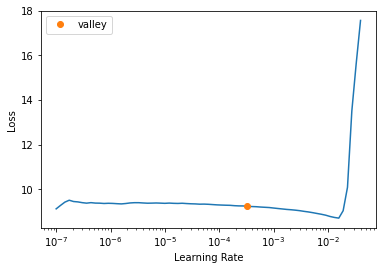

In [7]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(dls, model, loss_func=seq2seq_loss, 
                metrics=[seq2seq_acc, CorpusBLEUMetric(len(dls.vocab[1]))],
                cbs=[TeacherForcing(30, 3)])
learn.lr_find()

In [12]:
learn.fit_one_cycle(7, 2e-3)

epoch,train_loss,valid_loss,seq2seq_acc,corpus_bleu,time
0,3.267984,2.941255,0.587048,0.397089,02:52
1,2.432247,2.429537,0.637897,0.434980,02:32
2,2.510777,2.112346,0.674652,0.460755,02:31
3,2.059308,2.047936,0.683675,0.468946,02:30
4,2.099344,1.938624,0.697954,0.489107,02:30
5,2.067464,1.994792,0.692945,0.485352,02:29
6,2.176093,1.993718,0.693948,0.490502,02:28


In [14]:
learn.save(Path(os.getcwd())/"output/neural")

Path('/home/fastai2/notebooks/fastai_NLP/output/neural.pth')

In [8]:
learn.load(Path(os.getcwd())/"output/neural")

Here, the `xs`, `ys` and `zs` are our `inputs`, `targs` and `preds.argmax(1)` respectively, since they passed out as integers. Then, we get the str form, which are the `rxs`, `rys` and `rzs` by passing through our `GetPreds.get_predictions` function. 

In [14]:
inputs, preds, targs = learn.get_preds(with_input=True)
p = GetPreds(dls, inputs[0], preds, targs)

In [16]:
idx = 701
rx, ry, rz = p.get_predictions(idx)
x, y, z = inputs[0][idx], targs[idx], preds[idx]
rx, ry, rz

("xxbos quel est le nom du tribunal ou des juges qui ont pris la décision d' appel et le nombre d' appels ?",
 'xxbos what is the name of the court / judges who decided the xxunk ) and number of appeals ?',
 'xxbos what is the name of the court or judges who have to appeal to ? the of positions ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad')

In [10]:
def select_topk(outp, k=5):
    probs = F.softmax(outp, dim=-1)
    vals, idxs = probs.topk(k, dim=-1)
    return idxs[torch.randint(k, (1,))]

In [11]:
from random import choice

def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp, dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res, cumsum = [], 0

    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum > p: return idxs.new_tensor([choice(res)])

In [12]:
def decode(self, inp): 
    inp = inp[None]
    bs, sl = inp.size()
    hid, enc_out = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx
    enc_att = self.enc_att(enc_out)

    res = []
    for i in range(self.out_sl):
        hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
        dec_inp = select_nucleus(outp[0], p=0.3)
        # dec_inp = select_topk(outp[0], k=2)
        res.append(dec_inp)
        if (dec_inp == self.pad_idx).all(): break

    return torch.cat(res)

In [25]:
def predict_with_decode(learn, x, y):
    learn.model.eval()
    ds = learn.dls.train_ds
    with torch.no_grad(): 
        try: out = decode(learn.model, x)
        except Exception: out = decode(learn.model, x.cuda())
        rx, ry, rz = p.get_predictions(idx)
        # We overwrite rz since we don't need "argmax" anymore. 
        rz = itos(dls.vocab[1], out.cpu(), join=True, ignore_pad=True)
    return rx, ry, rz

In [29]:
rx, ry, rz = predict_with_decode(learn, x, y)
rz

'xxbos what is the name of the court or court who decided to appeal and the number of appeal ?'